## Modeling timeseries data with Gluon: using LSTM to predict AWS spot instance price

This notebook is an is the Gluon version of the [MXNet tutorial](https://github.com/sunilmallya/timeseries/blob/master/univariate_timeseries_forecasting_lstm.ipynb) along with animation of how the LSTM network learns over each epoch

Dataset: https://raw.githubusercontent.com/sunilmallya/mxnet-notebooks/master/python/tutorials/data/p2-east-1b.csv

In [1]:
import pandas
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

%matplotlib inline


df = pandas.read_csv('data/p2-east-1b.csv', usecols=[0,4], names=['date', 'cost'])

df.head()

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,date,cost
0,2017-05-08 21:42:56+00:00,0.2500
1,2017-05-08 21:41:01+00:00,0.2402
2,2017-05-08 21:40:05+00:00,0.2414
3,2017-05-08 21:42:56+00:00,0.2500
4,2017-05-08 21:41:01+00:00,0.2402


In [2]:
import dateutil.parser

values = df.values[::-1]

ticks = map(dateutil.parser.parse, values[:,0])
dataset = values[:,1]
dataset.shape

(7183,)

/usr/local/lib/python2.7/site-packages/dateutil/rrule.py:450: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


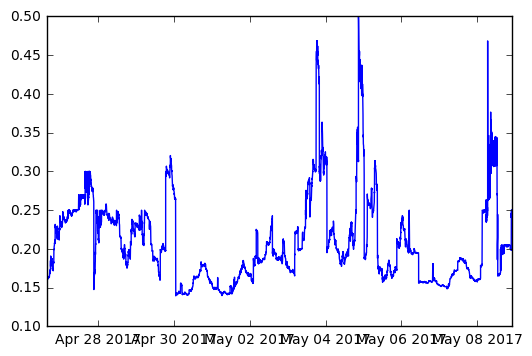

In [3]:
plt.plot(ticks, dataset)

In [4]:
# Tx = Tx-1, Tx-2 ; Window size = 2


from sklearn.preprocessing import MinMaxScaler

dataset = np.reshape(dataset, (len(dataset), 1))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

dataset[:5],  scaled_dataset[:5]

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[0.162],
        [0.1623],
        [0.1616],
        [0.161],
        [0.1613]], dtype=object), array([[ 0.06241331],
        [ 0.06324549],
        [ 0.06130374],
        [ 0.05963939],
        [ 0.06047157]]))

In [5]:
# align the data

seq_len = 2

x = scaled_dataset
y = scaled_dataset[: ,[-1]]

x[:5], y[:5]

dataX = []; dataY = []

for i in range(0, len(y)-seq_len):
    _x = x[i: i+seq_len]
    _y = y[i+seq_len]
    dataX.append(_x)
    dataY.append(_y)
    
dataX[0], dataY[0]

# Tx0, Tx1 => Tx2 
# Tx1, Tx2 => Tx3

(array([[ 0.06241331],
        [ 0.06324549]]), array([ 0.06130374]))

In [6]:
dataX[1], dataY[2]

(array([[ 0.06324549],
        [ 0.06130374]]), array([ 0.06047157]))

In [7]:
# Define Itertors 

#split the data
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) -  train_size

batch_size = 32

train_X, test_X = np.array(dataX[:train_size]).astype('float32'), np.array(dataX[train_size:]).astype('float32')
train_y, test_y = np.array(dataY[:train_size]).astype('float32'), np.array(dataY[train_size:]).astype('float32')

#train_iter = mx.io.NDArrayIter(data=trainX, label=trainY, 
#                               batch_size=batch_size, shuffle=True)

#val_iter = mx.io.NDArrayIter(data=testX, label=testY, 
#                               batch_size=batch_size, shuffle=False)

In [ ]:
import mxnet as mx
import numpy as np
import math
import time

from mxnet import nd, autograd
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

def get_data(batch, iter_type, ctx=mx.cpu()):
    ''' get data and label from the iterator/dataloader '''
    if iter_type == 'mxiter':
        X_train = batch.data[0].as_in_context(ctx)
        Y_train = batch.label[0].as_in_context(ctx)
    else:
        X_train = batch[0].as_in_context(ctx)
        Y_train = batch[1].as_in_context(ctx)

    return X_train, Y_train
    
class BaseRNNRegressor(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseRNNRegressor, self).__init__()
        self.ctx = ctx
        self.rnn = None
        self.rnn_size = None
        self.batch_size = None
        
    #@override 
    def build_model(self, rnn_type='lstm', rnn_size=128, n_layer=1, n_out=1):
        self.rnn_size = rnn_size
        self.n_layer = n_layer
        self.net = mx.gluon.rnn.LSTM(rnn_size, n_layer, 'NTC')
        self.output = mx.gluon.nn.Dense(n_out)

    #@override 
    def forward(self, inp, hidden):
        rnn_out, hidden = self.net(inp, hidden)
        #print rnn_out.shape, hidden[0].shape
        #logits = self.output(rnn_out.reshape((-1, self.rnn_size)))
        rnn_out = rnn_out[:, rnn_out.shape[1]-1, :]
        logits = self.output(rnn_out)
        return logits, hidden
        
    def detach(self, arrs):
        return [arr.detach() for arr in arrs]

    def compile_model(self, optimizer='adam', lr=1E-3):
        self.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        self.loss = mx.gluon.loss.L1Loss()
        self.optimizer = mx.gluon.Trainer(self.collect_params(), 
                                    optimizer, {'learning_rate': lr})


    def evaluate_accuracy(self, data_iterator, metric='mae', iter_type='mxiter'):
        met = mx.metric.MAE()
        
        init_state = mx.nd.zeros((1, self.batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        
        for i, batch in enumerate(data_iterator):
            data, label = get_data(batch, iter_type)
            preds, hidden = self.forward(data, hidden)
            met.update(labels=label, preds=preds)
        return met.get()
    
    
    def predict(self, data_iterator, iter_type='numpy', batch_size=128):
        batch_pred_list = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = get_data(batch, iter_type)
            output, hidden = self.forward(data, hidden)
            batch_pred_list.append(output.asnumpy())
        return np.vstack(batch_pred_list)
    
    def fit(self, train_data, test_data, epochs, batch_size=32):
        self.batch_size = batch_size
        moving_loss = 0.
        train_loss = []
        val_loss = []
        iter_type = 'numpy'
        
        # Can take MX NDArrayIter, or DataLoader
        if isinstance(train_data, mx.io.NDArrayIter):
            train_iter = train_data
            #total_batches = train_iter.num_data // train_iter.batch_size
            test_iter = test_data
            iter_type = 'mxiter'

        elif isinstance(train_data, list):
            if isinstance(train_data[0], np.ndarray) and isinstance(train_data[1], np.ndarray):
                X, y = train_data[0], train_data[1]
                #print type(test_data[0])
                #if isinstance(test_data[0], np.ndarray):
                #    raise ValueError("need test array to be numpy array")
                tX, ty = test_data[0], test_data[1]
                train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y), 
                                    batch_size=batch_size, shuffle=True, last_batch='discard')
                test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
                #total_batches = len(X) // batch_size
        else:
            raise "pass mxnet ndarray or numpy array"

        print "data type:", type(train_data), type(test_data), iter_type

        init_state = mx.nd.zeros((1, batch_size, self.rnn_size), ctx)
        hidden = [init_state] * 2
        
        
        
        ### INIT PLOT
        
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()

        fig.canvas.draw()  

        ###
        
        for e in range(epochs):
            if isinstance(train_iter, mx.io.NDArrayIter): train_iter.reset()
            yhat = []
            for i, batch in enumerate(train_iter):
                data, label = get_data(batch, iter_type)
                #print "d", data.shape, label.shape
                with autograd.record(train_mode=True):
                    Y_pred, hidden = self.forward(data, hidden)
                    hidden = self.detach(hidden)
                    #print Y_pred.shape, label.shape
                    loss = self.loss(Y_pred, label) 
                    yhat.extend(Y_pred)
                loss.backward()                                        
                self.optimizer.step(batch_size)

                if i == 0:
                    moving_loss = nd.mean(loss).asscalar()
                else:
                    moving_loss = .99 * moving_loss + .01 * mx.nd.mean(loss).asscalar()
            


            
            train_loss.append(moving_loss)
            test_err = self.evaluate_accuracy(test_iter, iter_type=iter_type)
            val_loss.append(test_err[1])
            #print("Epoch %s. Loss: %.10f Test MAE: %s" % (e, moving_loss, test_err))

            
            
            
            ## Plot animation ##

            test_pred = model.predict(test_iter, batch_size=batch_size)
            n_test_y = tX[:len(test_pred)]  #handle mx iter case
            test_plot = scaler.inverse_transform(test_pred)

            ax.clear()
            t_plot = np.empty_like(dataset)
            t_plot[:] = np.nan
            t_plot[-len(test_plot):] = test_plot 
            ax.plot(ticks, dataset, label="real data")
            ax.plot(ticks, t_plot, label= "pred")
            plt.title("change in prediction after every batch")
            ax.legend()
            fig.canvas.draw()  
            time.sleep(0.0250)
            plt.ioff()
                
            ## End Animation
            
        return train_loss, val_loss
    
ctx = mx.cpu()
epochs = 10
model = BaseRNNRegressor(ctx)
model.build_model('lstm', rnn_size=4, n_layer=1, n_out=1)
model.compile_model(optimizer='adam')
t_loss, v_loss = model.fit([train_X, train_y], [test_X, test_y], epochs=epochs, batch_size=batch_size)

In [9]:
test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(test_X, test_y), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
test_pred = model.predict(test_iter, batch_size=batch_size)
n_test_y = test_y[:len(test_pred)]
print np.mean((test_pred - n_test_y)**2)

test_plot = scaler.inverse_transform(test_pred)
#test_plot[:5], n_test_y[:5]

0.000785651


<IPython.core.display.Javascript object>


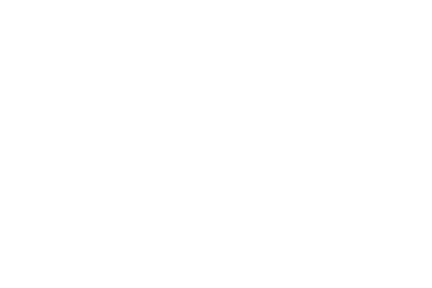

In [10]:
t_plot = np.empty_like(dataset)
t_plot[:] = np.nan
t_plot[-len(test_plot):] = test_plot 
plt.plot(ticks, dataset, label="real data")
plt.plot(ticks, t_plot, label= "pred")
plt.legend()